## Baseline: LinearRegression

Importo las librerias que utilizare.

In [1]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
)

from sklearn.linear_model import LinearRegression
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt   
import scipy as sp

### Lectura de archivos

Leo arc shippings

In [2]:
arc = pd.read_csv('silkroad_shippings.csv')

In [3]:
arc.head(4)

,item_id,description,est_delivery,price,timestamp
0,jj-luna-privacy-ebooks,ebook link,1 day,0.000000,2014-02-23T05:39:22
1,the-morality-of-capitalism,letter,4 days,0.001722,2014-02-23T05:39:29
2,survive,small book (domestic),4 days,0.017217,2014-02-23T05:39:33
3,a-non-religious-new-testament,media mail parcel (domestic),4 days,0.006870,2014-02-23T05:39:37


Leo arc reviews

In [4]:
arc2 = pd.read_csv('silkroad_reviews.csv')

In [5]:
arc2 = arc2[['item_id','rating']]

Hay varios ratings asociados al mismo item_id, por lo tanto voy a quedarme con el rating promedio por cada item_id.

In [6]:
group = arc2.groupby('item_id').agg({'rating':'mean'})

In [7]:
group.shape

(12749, 1)

In [8]:
group.reset_index(inplace=True)

Realizo el join entre los dos arc que leí.

In [9]:
join = arc.merge(group,how='left')

Voy a trabajar con todos los precios del shipping menores o igual a 15 bitcoins.

In [10]:
cota_bit = 15 

In [11]:
#achico mi rango de precios 
join = join[join['price'] <=cota_bit] 

### Creo el modelo inicial

In [12]:
model = LinearRegression()

### Realizo la división entre Train y Validation

Tomo el limite para dividir el validation del train

In [13]:
indice_limite = int(join.shape[0] * 0.8 )

In [14]:
limite = join.index[indice_limite]

Validation

In [15]:
filtroV = join.index > limite

In [16]:
validation = join[filtroV]

In [17]:
validation.shape

(112052, 6)

In [18]:
labelValidation = validation['price']

In [19]:
del(validation['price'])

Train

In [20]:
filtroT = join.index <= limite

In [21]:
train = join[filtroT]

In [22]:
train.shape

(448213, 6)

In [23]:
labelTrain=train['price']

In [24]:
del(train['price'])

Libero RAM

In [25]:
del arc
del arc2
del group

### Encodings

Diccionario de encodigns

In [26]:
encoding = {}

In [27]:
encoding2= {}

Funciones para los encodings.

In [28]:
def countVect(df,columna,dic):
    if columna not in dic:
        #dic[columna] = CountVectorizer(max_features =5000)#(max_features =10)
        dic[columna]=Pipeline([('countV', CountVectorizer(max_features =5000)), ('pca', TruncatedSVD(n_components=50, n_iter=3, random_state=0))])
        col_encoded = dic[columna].fit_transform(df[columna].fillna('desconocido')).astype(int)#.toarray()
    else:
        col_encoded = dic[columna].transform(df[columna].fillna('desconocido')).astype(int)#.toarray()
    col_encoded = pd.DataFrame(col_encoded).add_prefix(columna+ '_enconded_').fillna(0) #imputacion de nulos
    del(df[columna])
    df_nuevo = pd.concat([df.reset_index(drop=True),col_encoded], axis=1)
    return df_nuevo
    #la imputacion de nulos se realiza reemplazando los mismos por 'desconocido'

In [29]:
def ordinal_enc(df,dic):
    for column in df.columns:
        if df[column].dtypes==object:
            dic[column] = OrdinalEncoder(handle_unknown='ignore')
            df[column] = dic[column].fit_transform(df[column].astype(str).values.reshape(-1, 1))
    if df[column].dtype==object:
        df[column] = dic[column].transform(df[column].astype(str).values.reshape(-1, 1))
    df.fillna(-1,inplace=True) #imputacion de nulos
    return(df)

### Train

In [30]:
del(train['timestamp'])

Realizo los encodings en el train

In [31]:
train = countVect(train,'description',encoding)

In [32]:
train = ordinal_enc(train,encoding)

Muestro los encoders

In [33]:
encoding

{'description': Pipeline(steps=[('countV', CountVectorizer(max_features=5000)),
                 ('pca',
                  TruncatedSVD(n_components=50, n_iter=3, random_state=0))]),
 'item_id': OrdinalEncoder(handle_unknown='ignore'),
 'est_delivery': OrdinalEncoder(handle_unknown='ignore')}

### Entreno el modelo

In [34]:
model.fit(train, labelTrain)

LinearRegression()

### Validation

In [35]:
del(validation['timestamp'])

Realizo los encodings en el validation

In [36]:
validation = countVect(validation,'description',encoding)

In [37]:
validation = ordinal_enc(validation,encoding)

### Realizo la prediccion

In [38]:
y_predict = model.predict(validation)

In [39]:
y_predict

array([0.03682352, 0.03635886, 0.03403555, ..., 0.04097774, 0.04515969,
       0.044629  ])

### Calculo de las metricas de medicion
* Error cuadratico medio
* Error absoluto medio

In [40]:
mean_squared_error(labelValidation,y_predict)

0.02019115835106849

In [41]:
mean_absolute_error(labelValidation,y_predict)

0.04216800340223399

### Curva de calibración

In [42]:
r, p = sp.stats.pearsonr(labelValidation, y_predict)
r2 = r**2
print('r2: ', r2, ' p: ',p)

r2:  0.01584182462427999  p:  0.0


Text(0.8, 0.9, 'r2=0.02, p=0')

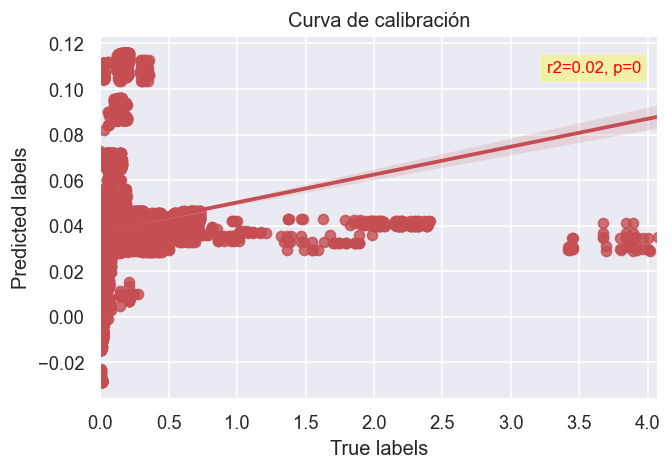

In [43]:
sns.set(rc={"figure.dpi":120})
curvaCalibracion_caso1 = sns.regplot(labelValidation, y_predict, color='r')
curvaCalibracion_caso1.set_xlabel('True labels', fontsize = 12)
curvaCalibracion_caso1.set_ylabel('Predicted labels', fontsize = 12)
curvaCalibracion_caso1.set_title('Curva de calibración', fontsize = 12)
curvaCalibracion_caso1.text(.8, .9, 'r2={:.2f}, p={:.2g}'.format(r2, p),
            transform=curvaCalibracion_caso1.transAxes,fontdict=dict(color='red',size=10),
                      bbox=dict(facecolor='yellow',alpha=0.3))

### Residual Plots

Text(41.87500000000001, 0.5, 'Predicted labels')

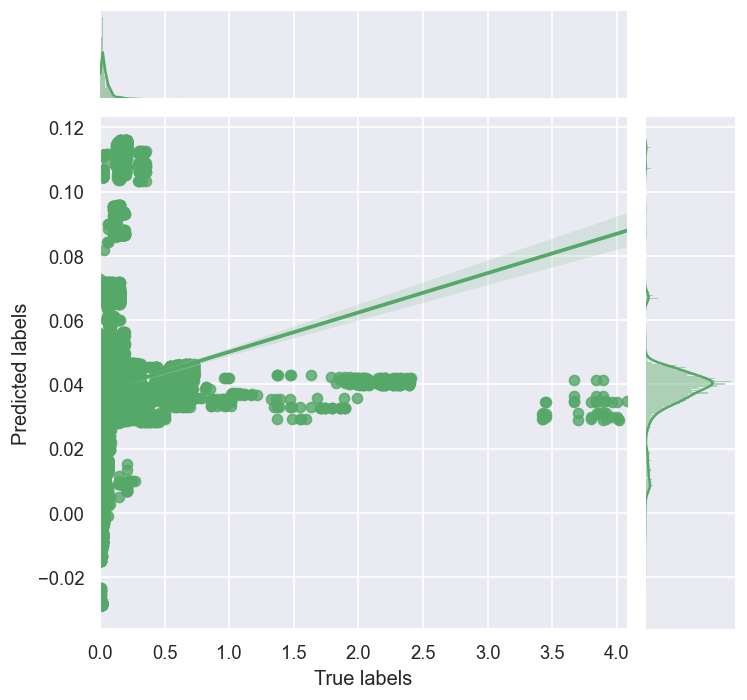

In [44]:
sns.set(rc={"figure.dpi":120})
caso_uno = sns.jointplot(x = labelValidation, y = y_predict, kind="reg",color = 'g')
caso_uno.ax_joint.set_xlabel('True labels', fontsize = 12)
caso_uno.ax_joint.set_ylabel('Predicted labels', fontsize = 12)
#el de arriba es el label, el del costado es la prediccion

In [45]:
info_histo = (labelValidation-y_predict)

Text(0.5, 1.0, 'Distribución gaussiana del error')

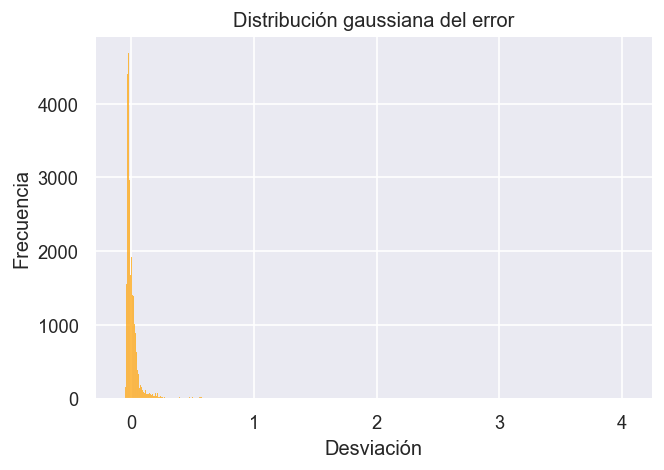

In [46]:
sns.set(rc={"figure.dpi":120})
hist_uno =sns.histplot(x=info_histo,color='orange')
hist_uno.set_xlabel('Desviación', fontsize = 12)
hist_uno.set_ylabel('Frecuencia', fontsize = 12)
hist_uno.set_title('Distribución gaussiana del error', fontsize = 12)

In [47]:
del train
del validation

Despues de ver este primer analisis, decidi trabajar con un nuevo modelo donde mi label ahora sea el precio pero en euros. La razon de mi decision es, dado que el bitcoin cambia de valor alocadamente, no me da buen augurio a la hora de predecir, dado que es tan inestable. Por lo tanto, trabajare en el ***modelo dos*** con esta modificacion ya realizada.

## Modelos Dos

Leo el arc de bitcoins

In [48]:
bit = pd.read_csv('bitcoins.csv')

In [49]:
bit['Date'] = pd.to_datetime(bit['Date']).dt.strftime('%Y-%m-%d')

In [50]:
bit = bit[['Date','Price']].rename(columns={'Price':'EuroPrice'}) 

Cambio el formato de la fecha del join

In [51]:
join['timestamp'] =pd.to_datetime(join["timestamp"]).dt.strftime('%Y-%m-%d')  

In [52]:
merge = join.merge(bit,left_on='timestamp',right_on ='Date',how = 'left')

In [53]:
del(merge['Date'])

In [54]:
merge.reset_index(inplace=True)

In [55]:
del(merge['index'])

In [56]:
merge = merge.sort_values(by='timestamp', ascending=True)

In [57]:
merge.shape

(560265, 7)

Paso a la modeda euro los bitcoins

In [58]:
merge['bit_en_euro'] = merge['price']*merge['EuroPrice']

In [59]:
del(merge['price'])
del(merge['EuroPrice'])

Voy a trabajar con todos los precios del shipping menores o igual a 100 Euros.

In [60]:
cota_euro =100

In [61]:
#achico mi rango de precios 
merge = merge[merge['bit_en_euro'] <= cota_euro] 

In [62]:
merge.shape

(552367, 6)

Tomo el límite entre el train y el validation.

In [63]:
index_limite = int(merge.shape[0] * 0.8 )

In [64]:
limite = merge.index[index_limite]

### Train

In [65]:
train2 =  merge[merge.index <= limite]

In [66]:
del(train2['timestamp'])

Defino el label del train

In [67]:
trainLabel = train2['bit_en_euro']

In [68]:
del(train2['bit_en_euro'])

Realizo los encodings en el train

In [69]:
train2 = countVect(train2,'description',encoding2)

In [70]:
train2 = ordinal_enc(train2,encoding2)

### Entreno el modelo

In [71]:
model.fit(train2, trainLabel)

LinearRegression()

Muestro los encoders

In [72]:
encoding2

{'description': Pipeline(steps=[('countV', CountVectorizer(max_features=5000)),
                 ('pca',
                  TruncatedSVD(n_components=50, n_iter=3, random_state=0))]),
 'item_id': OrdinalEncoder(handle_unknown='ignore'),
 'est_delivery': OrdinalEncoder(handle_unknown='ignore')}

### Validation

In [73]:
validation2 =  merge[merge.index > limite]

In [74]:
del(validation2['timestamp'])

Defino el label del validation

In [75]:
validationLabel = validation2['bit_en_euro']

In [76]:
del(validation2['bit_en_euro'])

Realizo los encodings en el validation

In [77]:
validation2 = countVect(validation2,'description',encoding2)

In [78]:
validation2 = ordinal_enc(validation2,encoding2)

### Prediccion

In [79]:
y_predict2 = model.predict(validation2)

### Calculo de las metricas de medicion
* Error cuadratico medio
* Error absoluto medio

In [80]:
mean_squared_error(validationLabel,y_predict2)

156.2626709425359

In [81]:
mean_absolute_error(validationLabel,  y_predict2)

7.548364567346534

### Curva de calibración

In [82]:
r, p = sp.stats.pearsonr(validationLabel, y_predict2)
r2 = r**2
print('r2: ', r2, ' p: ',p)

r2:  0.1922656800730355  p:  0.0


Text(0.8, 0.7, 'r2=0.19, p=0')

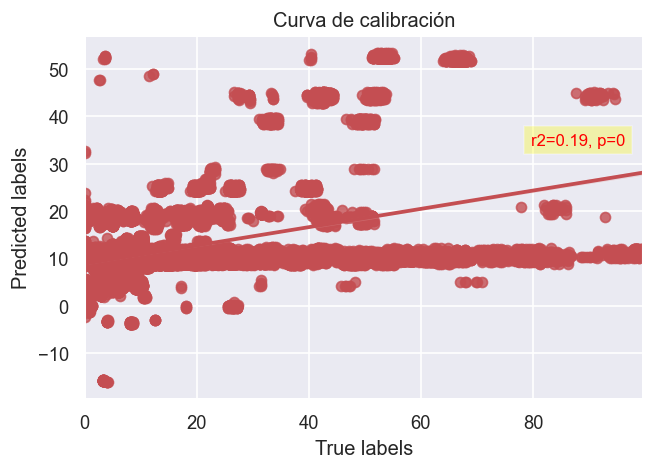

In [83]:
sns.set(rc={"figure.dpi":120})
curvaCalibracion_caso2 = sns.regplot(x=validationLabel, y=y_predict2, color='r')
curvaCalibracion_caso2.set_xlabel('True labels', fontsize = 12)
curvaCalibracion_caso2.set_ylabel('Predicted labels', fontsize = 12)
curvaCalibracion_caso2.set_title('Curva de calibración', fontsize = 12)
curvaCalibracion_caso2.text(.8, .7, 'r2={:.2f}, p={:.2g}'.format(r2, p),
            transform=curvaCalibracion_caso2.transAxes,fontdict=dict(color='red',size=10),
                      bbox=dict(facecolor='yellow',alpha=0.3))

### Residual Plots

Text(41.87500000000001, 0.5, 'Predicted labels')

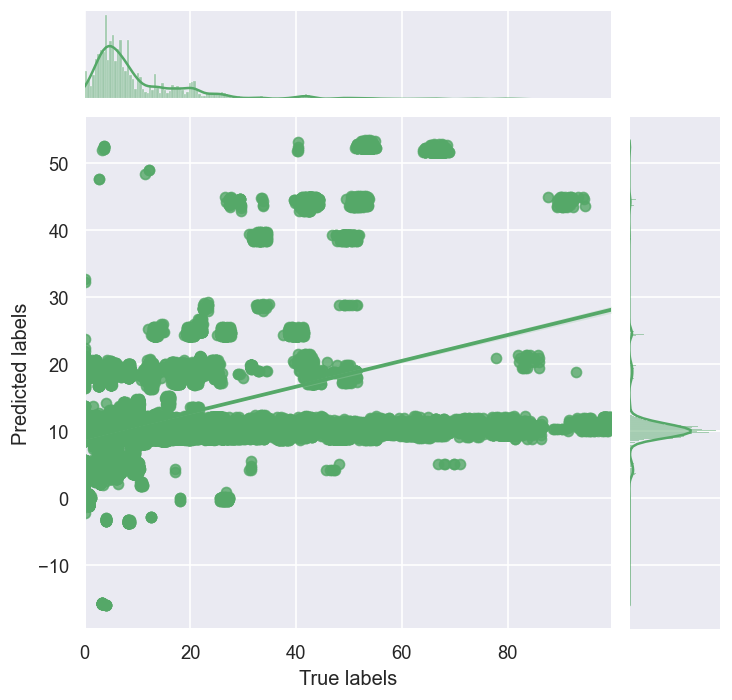

In [84]:
sns.set(rc={"figure.dpi":120})
caso_dos = sns.jointplot(x = validationLabel, y = y_predict2, kind="reg",color='g')
caso_dos.ax_joint.set_xlabel('True labels', fontsize = 12)
caso_dos.ax_joint.set_ylabel('Predicted labels', fontsize = 12)

In [85]:
info_histo2 = (validationLabel-y_predict2)

Text(0.5, 1.0, 'Distribución gaussiana del error')

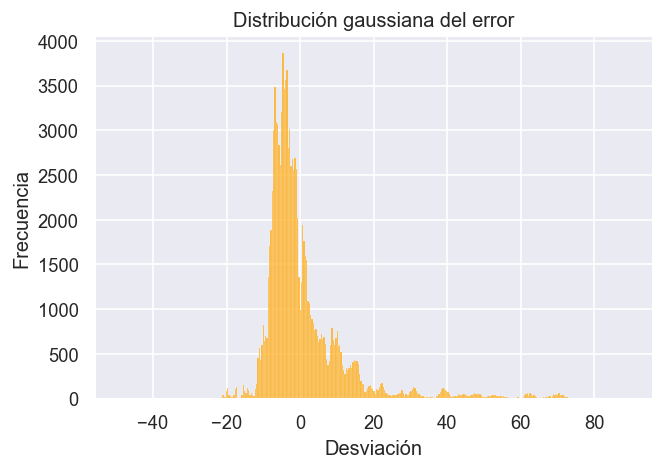

In [86]:
sns.set(rc={"figure.dpi":120})
hist_dos =sns.histplot(x=info_histo2,color='orange')
hist_dos.set_xlabel('Desviación', fontsize = 12)
hist_dos.set_ylabel('Frecuencia', fontsize = 12)
hist_dos.set_title('Distribución gaussiana del error', fontsize = 12)

***Conclusión:*** Si bien la distribución del residuo del shipping en euros no es perfecta, resulta mejor que la distribución del shipping en bitcoins, al igual que la curva de calibración. Es por eso, que podemos afirmar que ha sido un acierto trabajar con el precio del shipping en euros, por lo tanto, en el siguiente modelo solo trabajare con el precio del shipping en euros.